In [248]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from glob import glob
from collections import defaultdict

In [249]:
sns.set_theme()
sns.set_context("talk", font_scale=1.7)#, rc={"font.size": 7})
sns.set_style(style={'xtick.bottom': True,'ytick.left': True, 'axes.edgecolor': 'black'})

In [250]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/motif_predictions/split_75_25/'

In [280]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

#train_df = pd.read_csv(data_dir + 'train.csv').set_index('seq_name').squeeze()
#test_df = pd.concat([train_df,test_df])

In [281]:
motif_len = 5 #5 or 6

In [282]:
eclip_pos = pd.read_csv(data_dir + '../../eCLIP/data/eCLIP.3utr.pos.PhyloP.bed', sep='\t',
                       names=['chrom','eclip_start','eclip_end','track','seq_name','PhyloP'])

#eclip_pos = pd.read_csv(data_dir + '../../eCLIP/data/eCLIP.3utr.pos_merged.bed', sep='\t',
#                       usecols=[0,1,2,6], names=['chrom','eclip_start','eclip_end','seq_name'])

eclip_pos['bound'] = True

eclip_neg = pd.read_csv(data_dir + '../../eCLIP/data/eCLIP.3utr.neg.PhyloP.bed', sep='\t',
                       names=['chrom','eclip_start','eclip_end','seq_name','PhyloP'])

eclip_neg['bound'] = False

In [283]:
utr_table = pd.read_csv(data_dir + '../../eCLIP/data/GRCh38.3utr_5Klimited.bed', sep='\t',
                       usecols=[0,1,2,3,5], names=['chrom','utr_start','utr_end','seq_name','strand'])

In [284]:
eclip_df = pd.concat([eclip_pos, eclip_neg])

eclip_df = eclip_df.merge(utr_table, how='left')

eclip_df = eclip_df[eclip_df.seq_name.apply(lambda x: x in test_df.index)]

eclip_df.drop_duplicates(subset=['chrom','eclip_start','eclip_end'], inplace=True)

In [285]:
eclip_df['eclip_start_rel'] = eclip_df.apply(lambda x: x.eclip_start-x.utr_start if x.strand=='+'
                                else x.utr_end-x.eclip_end, axis=1)

eclip_df['eclip_end_rel'] = eclip_df.apply(lambda x: x.eclip_end-x.utr_start if x.strand=='+'
                                else x.utr_end-x.eclip_start, axis=1)

In [310]:
models = {'Dinucl.':'dinucl','11-mer':'11_mer','Species-\nagnostic':'../species_agnostic/probas',
          'Species-\naware':'../species_aware/probas', 'DNABERT': 'dnabert/default/', 'PhyloP':None}

In [311]:
#models = {'Species-\nagnostic':'../species_agnostic/probas',
#          'Species-\naware':'../species_aware/probas', 'PhyloP':None}

In [312]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [313]:
def get_dnabert(res_path):
    res = {}
    for probas_file in glob(res_path + '*.npy'):
        seq_matching = pd.read_csv(probas_file.replace('/preds','/seq').replace('.npy','.csv')).set_index('seq_name').squeeze()
        probas = np.load(probas_file)
        s = 0
        for seq_name, seq in seq_matching.items():
            res[seq_name] = [x[mapping[seq[seq_idx]]] for seq_idx,x in enumerate(probas[s:s+len(seq),:])]
            s += len(seq)
        assert s==len(probas)
    return res

In [314]:
res = {}

for model, model_path in models.items():
    if model_path is None:
        continue
    if model!='DNABERT':
        with open(data_dir + model_path + '.pickle','rb') as f:
            res[model] = dict(pickle.load(f))
    else:
        res[model] = get_dnabert(data_dir + model_path)

In [315]:
regions_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    #if not seq_name in res['DNABERT']:
    #    continue
    for _, region in eclip_df[eclip_df.seq_name==seq_name].iterrows():
        motif = seq[region.eclip_start_rel:region.eclip_end_rel]
        motif_mapping = [list(range(len(motif))),list(map(lambda x:mapping[x],motif))]
        for model in models:
                if model == 'PhyloP':
                    regions_df.append(('PhyloP',region.bound,region.PhyloP))
                elif 'Species' in model:
                    avg_target_prob = np.mean(res[model][seq_name][region.eclip_start_rel:region.eclip_end_rel][motif_mapping[0], motif_mapping[1]])
                else:
                    avg_target_prob = np.mean(res[model][seq_name][region.eclip_start_rel:region.eclip_end_rel])
                regions_df.append((model,region.bound,avg_target_prob))
        

100%|██████████| 4534/4534 [00:12<00:00, 361.09it/s]


In [316]:
regions_df = pd.DataFrame(regions_df, columns=['model','bound','avg_target_prob'])

In [317]:
PhyloP_scores = regions_df.loc[regions_df.model=='PhyloP','avg_target_prob']

regions_df.loc[regions_df.model=='PhyloP','avg_target_prob'] = (PhyloP_scores-PhyloP_scores.min())/(PhyloP_scores.max()-PhyloP_scores.min())

/data/ouga/home/ag_gagneur/l_vilov/miniconda3/envs/svilov-python/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

11-mer_False vs. 11-mer_True: t-test independent samples with Benjamini-Hochberg correction, P_val:5.915e-123 t=2.371e+01
Dinucl._False vs. Dinucl._True: t-test independent samples with Benjamini-Hochberg correction, P_val:2.499e-44 t=1.399e+01
Species-
agnostic_False vs. Species-
agnostic_True: t-test independent samples with Benjamini-Hochberg correction, P_val:1.001e-70 t=1.784e+01
Species-
aware_False vs. Species-
aware_True: t-test independent samples with Benjamini-Hochberg correction, P_val:2.577e-62 t=1.671e+01
DNABERT_False vs. DNABERT_True: t-test independent samples with Benjamini-Hochberg correction, P_val:7.084e-105 t=2.185e+01
PhyloP_False vs. PhyloP_True: t-test independent samples with Benjamini-Hochberg correction, P_val:5.903e-58 t=-1.607e+01


<Figure size 640x480 with 0 Axes>

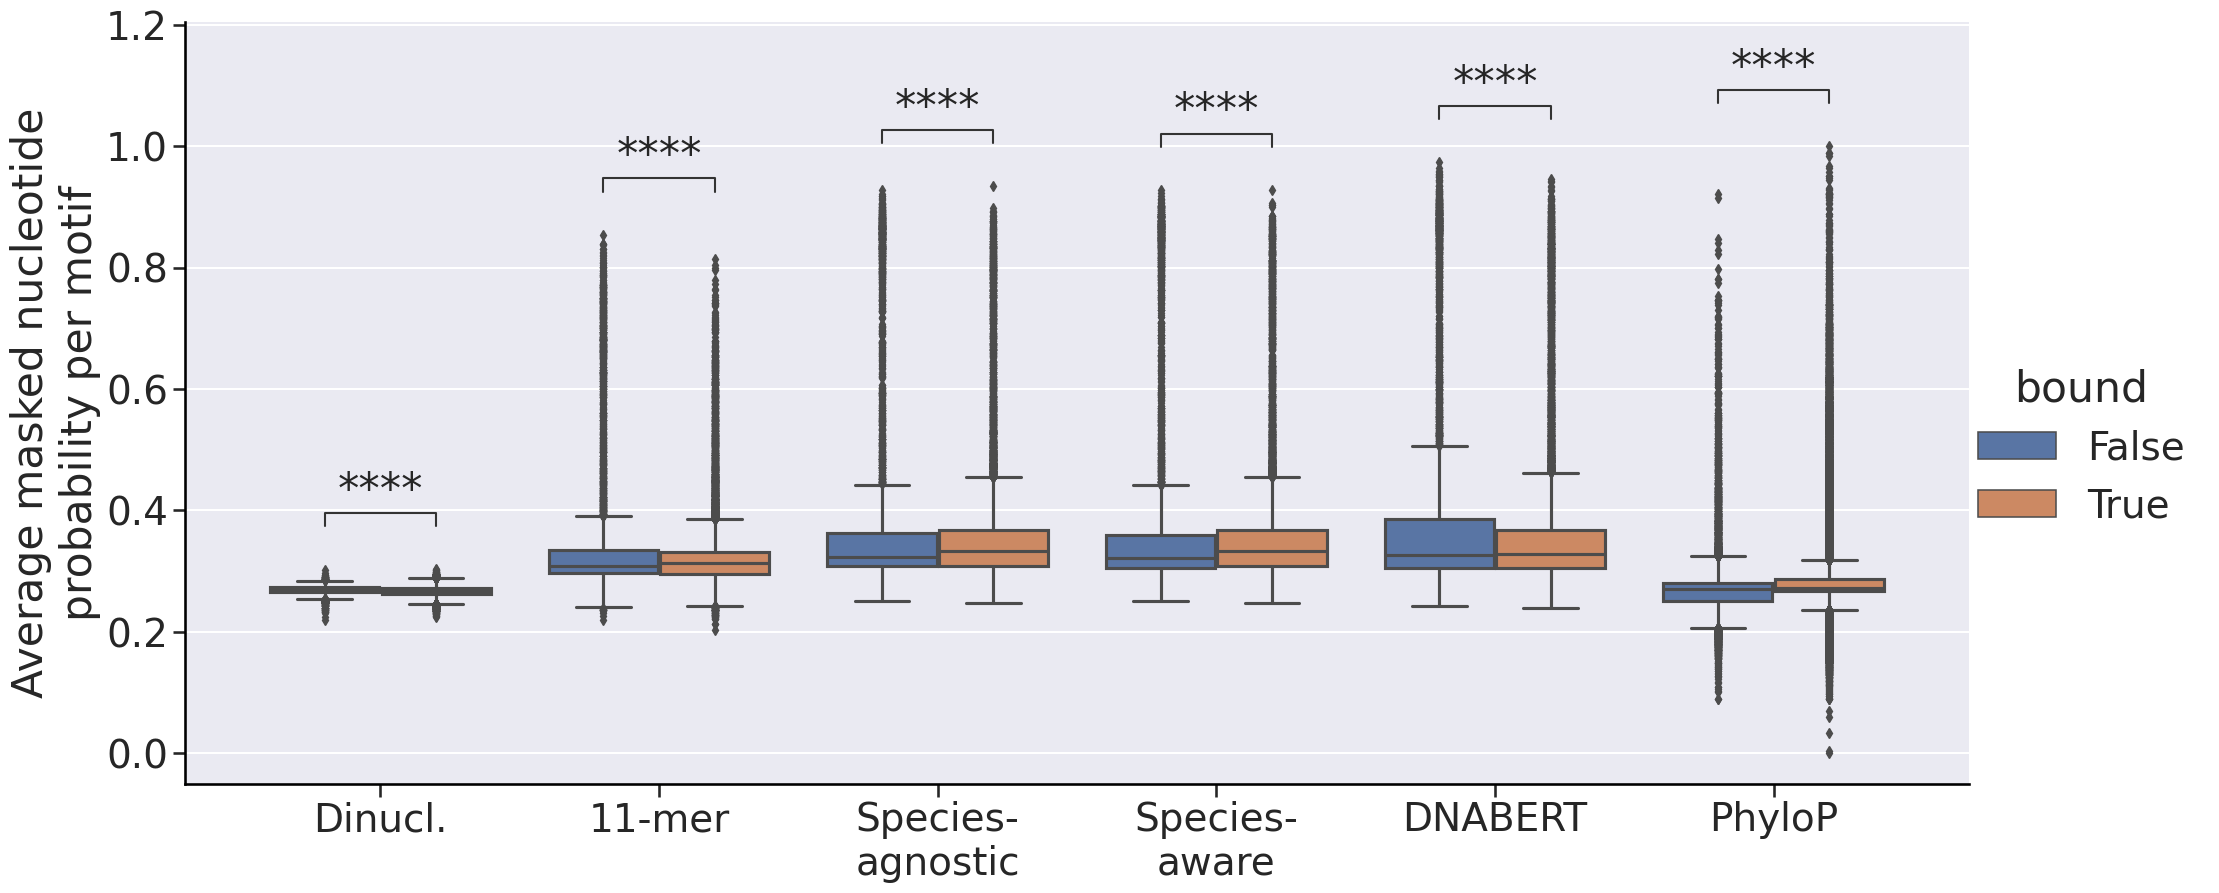

In [318]:
plt.clf()

g = sns.catplot(data=regions_df, x="model", y="avg_target_prob", hue="bound",
                kind="box", height=10, aspect=2.0, estimator=np.mean)#, palette=custom_colors)

#plt.xticks(rotation = 45, ticks = range(0,8),labels=motifs_df.label.unique())

pairs = [((model,True),(model,False)) for model in models]

for ax_n in g.axes:
    for ax in ax_n:
        annotator = Annotator(ax, pairs, data=regions_df, x="model", y="avg_target_prob", hue="bound")
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', comparisons_correction="BH")
        annotator.apply_and_annotate()
            
plt.xlabel("")
plt.ylabel("Average masked nucleotide\nprobability per motif")
plt.show()

In [323]:
for model in models:
    
    y_true, y_pred = zip(*regions_df.loc[regions_df.model==model,['bound','avg_target_prob']].values.tolist())
    roc_score = roc_auc_score(y_true, y_pred)
    print(model.replace('\n',''), f'{roc_score:.3}')

Dinucl. 0.429
11-mer 0.497
Species-agnostic 0.522
Species-aware 0.535
DNABERT 0.477
PhyloP 0.554
